# Rasters with GDAL

Last class we got comfortable with using Numpy to manipulate very large arrays. These arrays could be any dimension, but we focused on 1 and 2-dimensional arrays. Today we will work with "rasters", which are 2-dimensional Numpy arrays.

For spatial data like rasters, the amazing workhorse is GDAL. You might have heard of this in the R context from RGDAL. The open-source scientific computing stack is all interlinked. Under the hood, just like with Numpy, GDAL is implemented in very fast C-based code. The python bindings are just a way to access that code from python.

Like all python libraries, we need to import GDAL before we can use it. In the code blcok below, we import it from it's namespace (osgeo). GDAL is grouped with other spatial libraries that collectively are called OSGEO, but for now we will just import GDAL. The `from` command tells us where we are importing it from. We're also going to import a few

In [ ]:
from osgeo import gdal
import numpy as np
import os, random
import matplotlib.pyplot as plt

# We can check which version we're running by printing the "__version__" variable
print("GDAL's version is: " + gdal.__version__)
print(gdal)

The first thing we are going to do is use gdal to open a raster file. For this to work, you will need to have copied the class Data folder on our shared drive (top image) into your local directory so that it is "Next to" (or more technically "in the same directory as") your Repos directory.

![](images/paste-2.png)

![](images/paste-1.png)

If you organize your files this way, we will now be able to easily use **relative paths** to reference files in the data directory from within code in your Repos dir. The code block below will define this.

Once the data is in the rigbht folder, we will define a variable holding a string that is the path to our raster data. This is remarkably difficult (at least, as measured by how many hours I have wasted because my code pointed to the wrong place). The superior way to manage this is with RELATIVE PATHS. Here, we define the filename, the directory in relative terms, and then join them together using the os functions.

In [ ]:
lulc_filename = 'rwanda_lulc_2015.tif'

# the ../ notation means go up one level relative to your current working directory. This gets us outside of the course
# repository and into our Data directory
data_directory = '../../data' 

# Join them together (this will work across operating systems)
lulc_file_path = os.path.join(data_directory, lulc_filename)

print('lulc_file_path', lulc_file_path)

# Also check if the file exists
print("Does the file exist?", os.path.exists(lulc_file_path))

Did it work? No, it didn't (unless you made a lucky mistake!). It's easy to get confused by relative paths, accidentally missing a level or something. In my experience (and looking at what questions we've had come up so far in class), the majority of code errors come from pointing to a "path" that does not exist on your harddrive.

Relative filepaths are defined relative to the current working directory (CWD). One way to trouble-shoot missing paths, then, is to view the current working direcotry:

In [ ]:
print(os.getcwd())

Or to view the absolute path:

In [ ]:
os.path.abspath(data_directory)

Sometimes it can be useful to see what is in the directory you've specified (to help you figure out what's going on if it can't find the file)

In [ ]:
# This will not work! Because our directory is not there!

# contents = os.listdir(data_directory)
# print(contents)

## In-class micro-exercise

In the code block below, I want you to use the os.path.join() approach from earlier to correcly make relative paths pointing to the rwanda_lulc file and use os.path.exists() to show you found it.

In [ ]:
# Class activity workspace

# You might want to use os.path.join(...) and the variables you defined above. Hint, you will need to fix the data_directory location, but to do so, you will need to inspect your folder structure.

In [ ]:
# KEY

# Here is the correct path. We had to go up two more levels. This might feel funny, but relative paths are AWESOME.
data_directory = '../../../../data' 

# Join them together (this will work across operating systems)
lulc_file_path = os.path.join(data_directory, lulc_filename)

print('lulc_file_path', lulc_file_path)

# Also check if the file exists
print("Does the file exist?", os.path.exists(lulc_file_path))

## GDAL and opening the raster

Now that we know for sure that the file is there, we can use gdal and it's Open function using the DOT notation (technically its a "method" not a function, but you can ignore that. If you're actually curious about object-oriented programming, a method is just a function attached to an object.).

In [ ]:
lulc_dataset = gdal.Open(lulc_file_path)
print(lulc_dataset)

The dataset object holds information about the area and extent of the data, or the geotransform information

In [ ]:
geotransform = lulc_dataset.GetGeoTransform()
projection = lulc_dataset.GetProjection()

print('GDAL dataset geotransform', geotransform)
print('GDAL dataset projection', projection)

IMPORTANT ANNOYING NOTE: in programming, there are different conventions for identifying a place by rows, cols vs. x, y vs. upper-left, lower-right, etc. Numpy is denoted row, col but gdal is denoted X, Y (which flips the order). Just memorize that row = Y and col = X.

In [ ]:
n_rows = lulc_dataset.RasterYSize
print('Number of rows in a GDAL dataset', n_rows)

n_cols = lulc_dataset.RasterXSize
print('Number of columns in a GDAL dataset', n_cols)

Next, get the "band" of the dataset. Many datasets have multiple layers (e.g. NetCDFs). Geotiffs can have multiple bands but often have just 1. For now, grab band 1

In [ ]:
lulc_dataset_band = lulc_dataset.GetRasterBand(1)

The band object has information too, like the datatype of the geotiff:

In [ ]:
data_type = lulc_dataset_band.DataType
no_data_value = lulc_dataset_band.GetNoDataValue()

print('data_type', data_type)
print('no_data_value', no_data_value)

Finally, we can get the array from the band as a numpy array:

In [ ]:
array = lulc_dataset_band.ReadAsArray()
shape = array.shape

print('Look at the array itself', array)

## Plotting a raster

We are now going to use matplotlib. It is basically like ggplot and draws its inspiration from MATLAB notation. By convention, we'll import it into the variable name plt, which is an object that lets us use matplotlib plotting notation.

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(array)
plt.title('Land-use, land-cover')
plt.colorbar(orientation='horizontal')

# Uncomment this if you want to save it
# plt.savefig('lulc.png', dpi=300) 

plt.show()

This is super ugly for one primary reason: it has scaled the colorbar to the minimum and maximum values, which ends up coloring nearly everything close to the zero value. We're going to crop the values it shoes to not let the outliers define the colorbar range.

In [ ]:
import matplotlib.pyplot as plt

# The second (and often better) plotting method is to use plt to create a figure and one ore more axes.
# This is potentially confusing but is powerful. the Axes object we created (ax) is the plottable area (and there could be lots of axes)
# The figure contains all the axes and is responsible for organizing stuff.

fig = plt.figure(figsize=(8, 6))
fig.set_dpi(300)

ax = fig.add_subplot()

# Set the title of this ax object
ax.set_title('Land-use, land-cover')

# Using the ax we created, we call the imshow function on our array from earlier. This create a new "im" object
im = ax.imshow(array)

# To fix the outlier problem from before, we use the im object to set its limits.
im.set_clim(0, 200)

# Set the cbar to spectral
im.set_cmap('Spectral')

# Get the cmap
cmap = im.get_cmap()
cmap.set_over('white', alpha=1.0)

# Get rid of the numbers on the axes
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

# Increase the dpi
fig.set_dpi(300)


# Add the colorbar to the figure. It will generate its values from the im object.
fig.colorbar(im, orientation='horizontal', shrink=0.5)

plt.show()

## Copies versus Views in Numpy

Part of how Numpy arrays are fast is the only ever load or access data when it is needed. This means that if you don't tell numpy to make a copy of something, any new variable will point to the old array. More specifically, this only creates a new pointer to the same block of memory on your computer that holds the array. If we change c_view, c will also be changed. So in the below, c_view only points to the old data in c. This is called a "view" of the array.

In [ ]:
c_view = array

This also means that if you modify array, you will be modifying what you have in c_view.

If you really need a copy in memory, you can use the numpy method copy():

In [ ]:
d = array.copy()

This gives us a NEW array in a new block of memory, so changing array will not change d.

## Using Functions to make better code

- In the code above that loaded the raster as an array, you might be bothered that it took 3 whole lines instead of just 1. 
  - First off, why was it that way? It gave us much more control of what exactly is loaded into memory and when. 
    - If you were using, say, the Raster package in R, it would have loaded the entire raster into memory.
    - There are ways around this in R of course, but they're not as well-built into the language as they are in python.
- But still, if we know we want to just load all the data each time, could we make this easier?
  - YES! The Pythonic way would be to define your own function, which we will do now.

In [ ]:
# To review, the notation for a python function is "def" followed by the name of 
# the function, then the arguments in parentheses, followed by a colon.
# After the colon, everything indented is part of the function. 
# The function ends when the indentation ends.

# This function takes a single argument, `input_raster_path`, and 
# returns a numpy array containing the data stored at that path.
# This is exactly like above, but now it is much shorter to write and is reusable.

def load_array(input_raster_path):
    """Load a raster into a numpy array"""
    raster = gdal.Open(input_raster_path)
    band = raster.GetRasterBand(1)
    array = band.ReadAsArray()
    return array


# With the function defined, we can now use it to load our raster into a numpy array.
lulc_array = load_array(lulc_file_path)

# Often rather than looking at the data, I just look at the SHAPE of the data,
# which confirms that I actually loaded the thiing I thought I did.
print(lulc_array.shape)

# In our jupyter notebook, this load_array() function will be available 
# for any cell called after this cell, including in the in-class cooperative exercise below.

## In-class cooperative exercise

Suppose you were doing a regression to estimate at a national scale how changes in cropland cover led to GDP growth. Suppose you used the standard FAO estimates of how much cropland there is in each country. Suppose also you submitted your article to a reviewer who, in a very rude way, pointed out that in Rwanda, some of the agricultural land was Rainfed Cropland while other parts were cropland mixed in with Herbaceous tree cover. They insisted that you cannot publish your paper without excluding the Herbaceous tree cover from your definition of what counts as agricultural land. In reality, this is probably a stupid argument, but believe me, you sometimes get reviewers who insist on something like this.

For this exercise, I want you to use the Rwanda LULC map to calculate the total area of cropland in Rwanda while excluding Herbacious covered agricultural land. Fortunately, the LULC data we're using includes this information using the legend below.

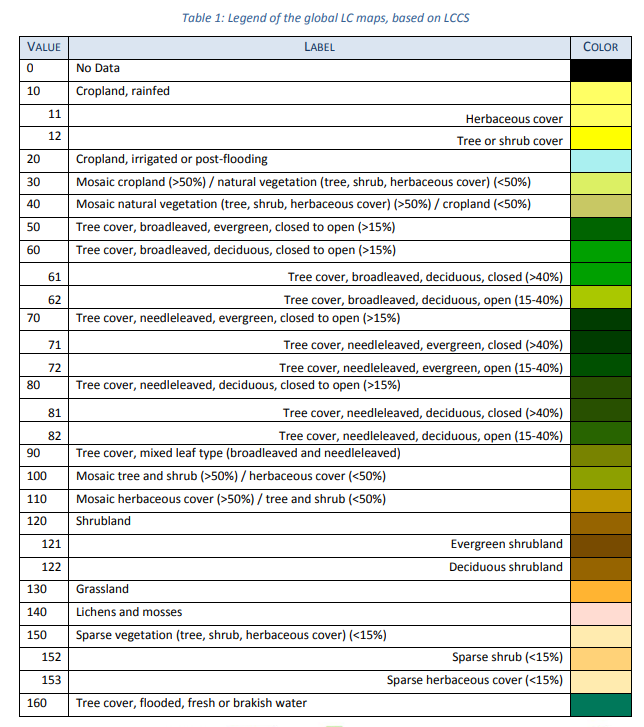

How can we extract out the amount of cropland that is not herbacious? Let's start by just exploring the data in the following code cell.



In [ ]:
import os
from osgeo import gdal
# I'm going to repeat the path inputs just so we can see them
data_directory = '../../../../data' 
lulc_filename = 'rwanda_lulc_2015.tif'
lulc_file_path = os.path.join(data_directory, lulc_filename)
print(os.path.abspath(lulc_file_path))
print("Does the file exist?", os.path.exists(lulc_file_path))

# Load it using our function
lulc_array = load_array(lulc_file_path)

# One very nice function in numpy is the np.unique() function
# It returns a list of all the unique values in an array
unique_values = np.unique(lulc_array)
print(unique_values)

# Looking at the values in the raster

- Comparing the values in the list, We can see that in Rwanda there are classes 6 different classes that have some degree of agriculture on them.
  - 10, 11, 12, 20, 30 40
  - Also notice that value 11, which represent Herbaceous Cover is present. 
    - The reviewer was right!
    - But how many pixels are there of this?

In [ ]:
# Numpy's Unique() function also can return counts of each unique value
unique_values, counts = np.unique(lulc_array, return_counts=True)

print('unique_values', unique_values)
print('counts', counts)

In [ ]:
# We could use the lists above to see how many pixels of class 11 exist, 
# but it is still kind of ugly. Instead, let's make this a dictionary

# We'll use the python zip function to zip the two lists together
counts_dict = dict(zip(unique_values, counts))
print(counts_dict)


In [ ]:
# We could even extract out just the value we care about from the dictionary above

number_of_herbaceous_cells = counts_dict[11]
print('number_of_herbaceous_cells', number_of_herbaceous_cells)

So now, to answer the reviewers' question, we would subtract the area represented in those pixels, plop it into our regression input table, and rerun the regression.